In [34]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [35]:
df = pd.read_csv('car_details.csv')

In [36]:
df.head()

,Marque,Modèle,Année,Type de carburant,Puissance fiscale,Kilométrage,Nombre de portes,Première main,État,Boîte à vitesses,Origine,Prix
0,Renault,Clio,2022,Essence,8 CV,35 000 - 39 999,5.0,Non,Très bon,Automatique,WW au Maroc,168 000 DH
1,Audi,A4,2014,Diesel,8 CV,170 000 - 179 999,5.0,NaN,Excellent,Manuelle,NaN,155 000 DH
2,Toyota,RAV 4,2014,Diesel,8 CV,200 000 - 249 999,5.0,Non,Excellent,Manuelle,WW au Maroc,146 000 DH
3,BMW,Série 5,2022,Electrique,10 CV,85 000 - 89 999,5.0,Oui,Excellent,Automatique,WW au Maroc,NaN
4,Peugeot,308,2021,Diesel,7 CV,70 000 - 74 999,5.0,Oui,Neuf,Manuelle,WW au Maroc,NaN


## <font color='red'>🧼 1. Data Cleaning (Préparation) </font>

<Axes: >

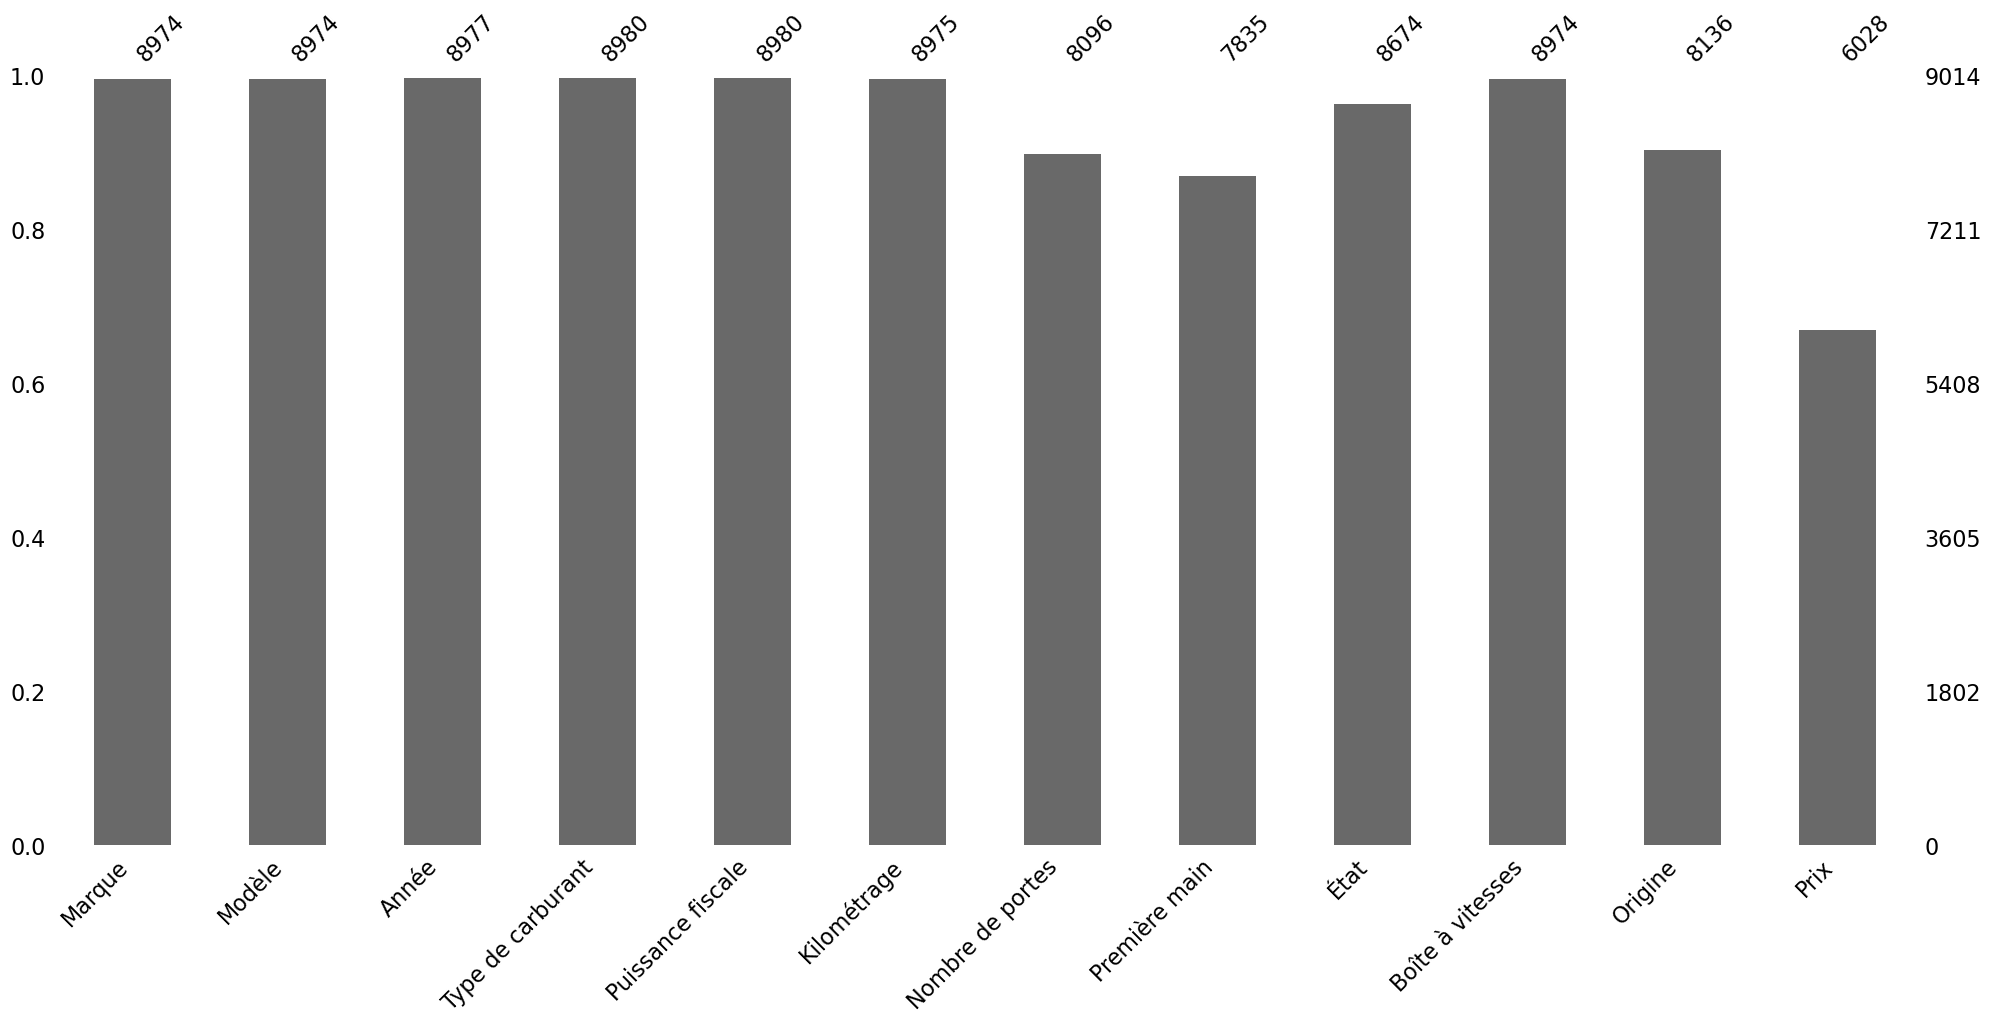

In [37]:
msno.bar(df)

In [38]:
df['Puissance fiscale'] = df['Puissance fiscale'].str.extract('(\d+)', expand=False).astype(float)

In [39]:
df['Prix'] = df['Prix'].str.replace(r'[^\d]','',regex=True)
df['Prix'] = pd.to_numeric(df['Prix'])

In [40]:
df['Kilométrage'] = df['Kilométrage'].astype(str).str.replace('Plus de ','',regex=False)

In [41]:
def calculate_average_km(kms):
    parts = kms.split('-')
    nums = [float(p.strip().replace(' ', '')) for p in parts]
    return sum(nums) / len(nums)
df['average_km'] = df['Kilométrage'].apply(calculate_average_km)
df = df.drop(columns=['Kilométrage'])

In [42]:
df['Année'] = df['Année'].str.replace(' ou plus ancien','',regex=False)
df['Année'] = pd.to_numeric(df['Année'])

In [43]:
df = df.drop_duplicates()

#### <font color='green'>🧩 PARTIE 1 : GÉRER LES VALEURS MANQUANTES</font>

In [44]:
df.isnull().mean().sort_values(ascending=False)

Prix                 0.328016
Première main        0.131413
Nombre de portes     0.102261
Origine              0.097326
État                 0.036842
Marque               0.002869
Modèle               0.002869
Boîte à vitesses     0.002869
average_km           0.002755
Année                0.002525
Type de carburant    0.002410
Puissance fiscale    0.002410
dtype: float64

In [45]:
df = df.dropna(subset=['Prix','État','Origine'])

In [46]:
from sklearn.impute import SimpleImputer
mode_imputer = SimpleImputer(strategy='most_frequent')
df['Nombre de portes'] = mode_imputer.fit_transform(df[['Nombre de portes']])

In [47]:
df['Première main'] = df['Première main'].fillna(df['Première main'].mode()[0])

In [48]:
df.isnull().sum().sum()

0

#### <font color='green'>🧩 PARTIE 2 : GÉRER LES VALEURS ABERRANTES</font>

In [49]:
df.head()

,Marque,Modèle,Année,Type de carburant,Puissance fiscale,Nombre de portes,Première main,État,Boîte à vitesses,Origine,Prix,average_km
0,Renault,Clio,2022.0,Essence,8.0,5.0,Non,Très bon,Automatique,WW au Maroc,168000.0,37499.5
2,Toyota,RAV 4,2014.0,Diesel,8.0,5.0,Non,Excellent,Manuelle,WW au Maroc,146000.0,224999.5
5,Peugeot,308,2018.0,Diesel,6.0,5.0,Non,Excellent,Manuelle,WW au Maroc,169000.0,32499.5
6,Seat,Toledo,2013.0,Diesel,6.0,5.0,Non,Excellent,Manuelle,WW au Maroc,120000.0,224999.5
7,Mini,CountryMan,2012.0,Essence,8.0,5.0,Non,Neuf,Manuelle,WW au Maroc,103000.0,124999.5


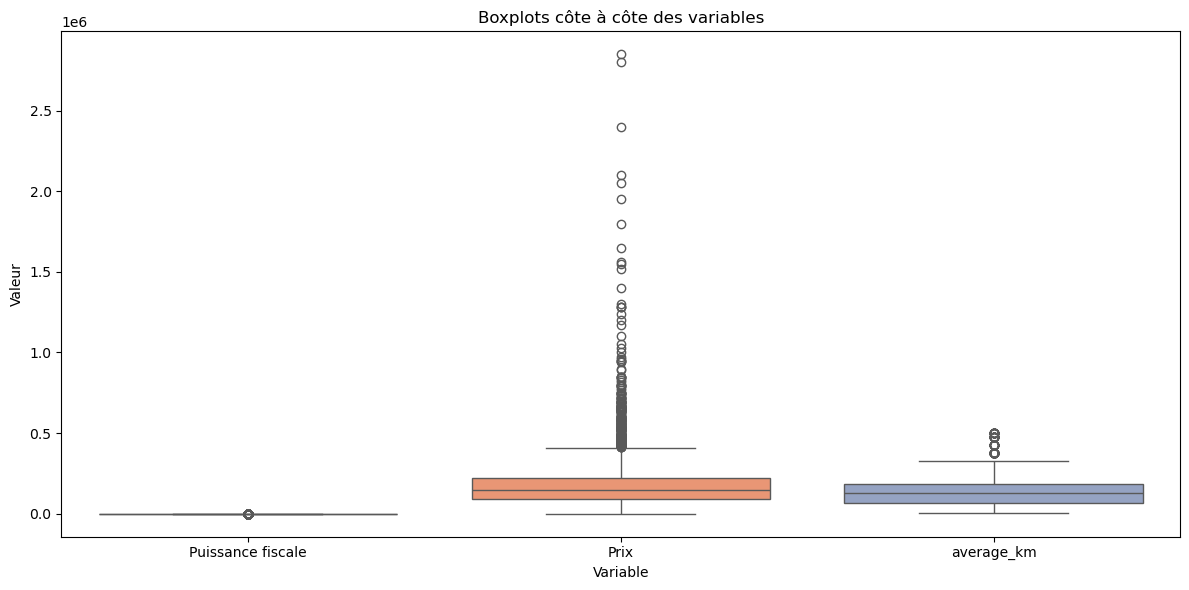

In [50]:
cols = ['Puissance fiscale','Prix','average_km']
df_long = df[cols].melt(var_name='Variable', value_name='Valeur')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Variable', y='Valeur', data=df_long,hue='Variable', palette='Set2')  # Set2, Set3, Paired, etc.
plt.title('Boxplots côte à côte des variables')
plt.tight_layout()
plt.show()

In [51]:
def remove_outliers(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[column] <= upper) & (df[column] >= lower)]

In [52]:
df = remove_outliers('Prix')
df = remove_outliers('average_km')

#### <font color='green'>🧩 PARTIE 3 : Feature enginnering</font>

In [53]:
df["Âge"] = 2025 - df["Année"]

#### <font color='green'>🧩 PARTIE 4 : Séparation des variables</font>

In [54]:
X = df.drop(columns=['Prix'])
y = df['Prix']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### <font color='green'>🧩 PARTIE 5 :Encodage + Standardisation</font>

In [55]:
num_cols=X_train.select_dtypes(include=['int','float']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_pipeline = Pipeline([
    ('scaler',StandardScaler())
])
categorical_pipeline = Pipeline([
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num',numeric_pipeline,num_cols),
    ('cat',categorical_pipeline,cat_cols)
])

## <font color='red'>2. ⚙️ Modèle  </font>

In [56]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
model = Pipeline([
    ('preprocessing',preprocessor),
    ('model',XGBRegressor(random_state=42)
)
])

In [57]:
from sklearn.model_selection import GridSearchCV
params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
}
grid_search = GridSearchCV(
    model,param_grid=params,cv=5,scoring='neg_mean_absolute_error',verbose=2
)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   0.1s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200; total time=   0.2s
[CV] END model__learning_rate=0.01, mo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Année',
                                                                          'Puissance '
                                                                          'fiscale',
                                                                          'Nombre '
                                                                          'de '
                                                                          'portes',
                                                                          'average_km',
                                                                          'Âge']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Marque',
                                                                          'Modèle',
                                                                          'Type '
                                                                          'de '
                                                                          'carburant',
                                                                          'Première '
                                                                          'main...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [64]:
best_model = grid_search.best_estimator_
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("✅ Évaluation sur le set de test :")
print(f"MAE : {mae:.2f} DH")
print(f"RMSE : {rmse:.2f} DH")
print(f"MSE : {mse:.2f} DH")
print(f"R² : {r2:.2f}")
print("🔧 Meilleurs hyperparamètres :", grid_search.best_params_)

✅ Évaluation sur le set de test :
MAE : 18642.43 DH
RMSE : 27883.82 DH
MSE : 777507292.19 DH
R² : 0.89
🔧 Meilleurs hyperparamètres : {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
